This notebook documents how the greatest weighted simple path is found between community route start and end nodes as found in the node ranking process.

In [1]:
import osmnx as ox
import networkx as nx
import matplotlib as plt
import config
import route_planning.helpers.route_planning_helper as helper

Load the graph where route start and end nodes are flagged.

Then create a subgraph for each community,
this will ensure simple paths found stay within a community's boundaries,
reducing computation time.

In [2]:
%%time
G = ox.load_graphml(filepath=f"{config.rp_graphml_path}/route_start_end_flagged.graphml")
helper.convert_edge_weights_to_floats(G)

community_graphs = helper.split_into_community_graphs(G)


CPU times: user 1.27 s, sys: 41.5 ms, total: 1.31 s
Wall time: 1.36 s


Adding a boolean community_route flag and community_route_order attribute to all nodes,
nodes on the eventual route will have this set to true and a numeric order value assigned

In [3]:
nx.set_node_attributes(G, False, "community_route")
nx.set_node_attributes(G, -1, "community_route_order")

It is unclear what cutoff value to use when finding the simple paths.

The cutoff is the depth the search for paths should have. A shorter depth means less run time for the search.

Trying a cutoff of 90 initially => no paths longer than 90 nodes. Timing the execution for comparison with other cutoff

In [4]:
%%time
routes_90cutoff = []
for graph in community_graphs:
    %time path = helper.find_highest_weighted_simple_path(graph, cutoff=90)
    print(f"----------------\n"
          f"community: {graph.nodes[path[0]]['community']}\n"
          f"total community weight: {graph.size(weight='weight')}\n"
          f"path weight: {helper.path_weight(graph, path)} \n"
          f"path: {path}\n"
          f"----------------\n")
    routes_90cutoff.append(path)

CPU times: user 48.3 ms, sys: 5.98 ms, total: 54.3 ms
Wall time: 59.5 ms
----------------
community: 0
total community weight: 10152.0
path weight: 2625.0 
path: [262459232, 2110993824, 2112562727, 2112562550, 258440720, 2112562637, 2112562834, 2114692416, 258430807, 2739577689, 2114692276, 1979831232, 1979830654, 6302291471, 339828849, 2114692414, 258430916, 2114692923, 2114692649, 2679019572, 2114649718, 1557357468, 1976663550, 258431037, 2114650574, 2114649685, 2354772221, 258431074, 1976663072, 2114649669, 258431117, 262482303, 2114650326, 2114649822, 2114649983, 2114650088, 2114650363, 1411721776, 529130810, 1411690486, 891663587, 2115875593, 2115875669, 2115875525, 2115875630, 891663458, 824799710, 2859800089, 1411703035, 528692201, 7313926535, 258661238, 1297382815, 155939804, 1411714691, 258601516, 1411690478, 1411702960, 258601523]
----------------

CPU times: user 4min 46s, sys: 1.19 s, total: 4min 47s
Wall time: 4min 54s
----------------
community: 1
total community weight: 

5 minutes to find all community routes.


Combine all route nodes and find the total number of community_route nodes

In [5]:
all_route_nodes_90cutoff = sum(routes_90cutoff, [])
len(all_route_nodes_90cutoff)

1125

1125 total nodes included in routes.

Make a copy of the graph and set community_route=True values if a node is on any of the found paths

In [6]:
G_90cutoff = G.copy()
for route in routes_90cutoff:
    i = 0
    for node in route:
        G_90cutoff.nodes[node]["community_route"] = True
        G_90cutoff.nodes[node]["community_route_order"] = i
        i += 1
community_route_nodes = [x for x,y in G_90cutoff.nodes(data=True) if y["community_route"]]
len(community_route_nodes)

1125

In [7]:
ox.save_graphml(G_90cutoff, filepath=f"{config.rp_graphml_path}/community_routes_cutoff90.graphml")

Plot the graph with community routes

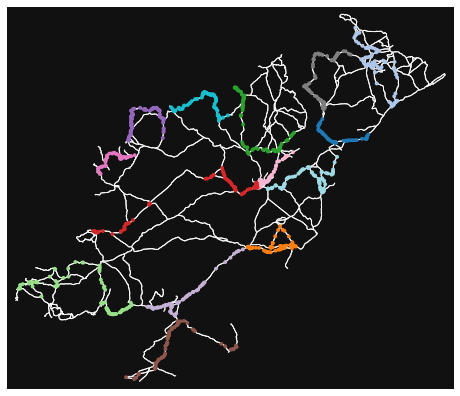

In [8]:
helper.plot_community_bus_routes(G_90cutoff)


Now trying with cutoff=100

In [9]:
%%time
routes_100cutoff = []
for graph in community_graphs:
    %time path = helper.find_highest_weighted_simple_path(graph, cutoff=100)
    print(f"----------------\n"
          f"community: {graph.nodes[path[0]]['community']}\n"
          f"total community weight: {graph.size(weight='weight')}\n"
          f"path weight: {helper.path_weight(graph, path)} \n"
          f"path: {path}\n"
          f"----------------\n")
    routes_100cutoff.append(path)

CPU times: user 40.8 ms, sys: 3.35 ms, total: 44.1 ms
Wall time: 43.7 ms
----------------
community: 0
total community weight: 10152.0
path weight: 2625.0 
path: [262459232, 2110993824, 2112562727, 2112562550, 258440720, 2112562637, 2112562834, 2114692416, 258430807, 2739577689, 2114692276, 1979831232, 1979830654, 6302291471, 339828849, 2114692414, 258430916, 2114692923, 2114692649, 2679019572, 2114649718, 1557357468, 1976663550, 258431037, 2114650574, 2114649685, 2354772221, 258431074, 1976663072, 2114649669, 258431117, 262482303, 2114650326, 2114649822, 2114649983, 2114650088, 2114650363, 1411721776, 529130810, 1411690486, 891663587, 2115875593, 2115875669, 2115875525, 2115875630, 891663458, 824799710, 2859800089, 1411703035, 528692201, 7313926535, 258661238, 1297382815, 155939804, 1411714691, 258601516, 1411690478, 1411702960, 258601523]
----------------

CPU times: user 14min 56s, sys: 4.11 s, total: 15min
Wall time: 15min 24s
----------------
community: 1
total community weight: 1

cutoff=100 took approx 17 minutes to find all community routes.

Find the number of nodes included in all paths found

In [10]:
all_route_nodes_100cutoff = sum(routes_100cutoff, [])
len(all_route_nodes_100cutoff)

1199

1199 nodes included in all routes - 74 more than when using cutoff=90 indicating slightly more coverage.

Make a copy of the graph and set community_route=True values if a node is on any of the found paths

In [11]:
G_100cutoff = G.copy()
for route in routes_100cutoff:
    i = 0
    for node in route:
        G_100cutoff.nodes[node]["community_route"] = True
        G_100cutoff.nodes[node]["community_route_order"] = i
        i += 1
community_route_nodes = [x for x,y in G_100cutoff.nodes(data=True) if y["community_route"]]
len(community_route_nodes)

1199

In [12]:
ox.save_graphml(G_100cutoff, filepath=f"{config.rp_graphml_path}/community_routes_cutoff100.graphml")

Plot the graph with community routes found with cutoff=100

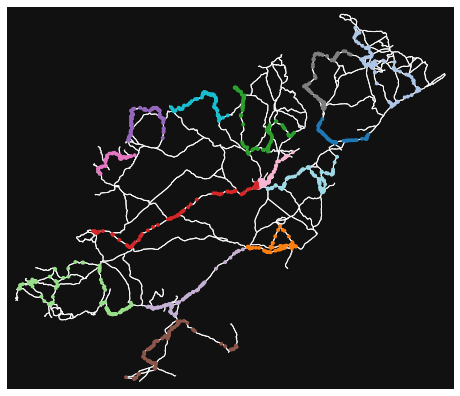

In [13]:
helper.plot_community_bus_routes(G_100cutoff)

Finding all simple paths with cutoff=110 to see if any significant increase in coverage is achievable

In [14]:
%%time
routes_110cutoff = []
for graph in community_graphs:
    %time path = helper.find_highest_weighted_simple_path(graph, cutoff=110)
    print(f"----------------\n"
          f"community: {graph.nodes[path[0]]['community']}\n"
          f"total community weight: {graph.size(weight='weight')}\n"
          f"path weight: {helper.path_weight(graph, path)} \n"
          f"path: {path}\n"
          f"----------------\n")
    routes_110cutoff.append(path)

CPU times: user 57.7 ms, sys: 0 ns, total: 57.7 ms
Wall time: 57.4 ms
----------------
community: 0
total community weight: 10152.0
path weight: 2625.0 
path: [262459232, 2110993824, 2112562727, 2112562550, 258440720, 2112562637, 2112562834, 2114692416, 258430807, 2739577689, 2114692276, 1979831232, 1979830654, 6302291471, 339828849, 2114692414, 258430916, 2114692923, 2114692649, 2679019572, 2114649718, 1557357468, 1976663550, 258431037, 2114650574, 2114649685, 2354772221, 258431074, 1976663072, 2114649669, 258431117, 262482303, 2114650326, 2114649822, 2114649983, 2114650088, 2114650363, 1411721776, 529130810, 1411690486, 891663587, 2115875593, 2115875669, 2115875525, 2115875630, 891663458, 824799710, 2859800089, 1411703035, 528692201, 7313926535, 258661238, 1297382815, 155939804, 1411714691, 258601516, 1411690478, 1411702960, 258601523]
----------------

CPU times: user 44min 7s, sys: 20.4 s, total: 44min 27s
Wall time: 46min 15s
----------------
community: 1
total community weight: 1

41 minutes run time for cutoff of 110

Find the number of nodes included in all paths found

In [15]:
all_route_nodes_110cutoff = sum(routes_110cutoff, [])
len(all_route_nodes_110cutoff)

1266

1266 total route nodes now, an increase of 67. About the same increase as from 90 to 100 cutoff, with the added time complexity this is as far as the cutoff will increased.

Make another copy of the graph and set community_route=True values if a node is on any of the found paths

In [16]:
G_110cutoff = G.copy()

for route in routes_110cutoff:
    i = 0
    for node in route:
        G_110cutoff.nodes[node]["community_route"] = True
        G_110cutoff.nodes[node]["community_route_order"] = i
        i += 1
community_route_nodes = [x for x,y in G_110cutoff.nodes(data=True) if y["community_route"]]
len(community_route_nodes)

1266

In [17]:
ox.save_graphml(G_110cutoff, filepath=f"{config.rp_graphml_path}/community_routes_cutoff110.graphml")

Plot the graph with community routes for cutoff=110

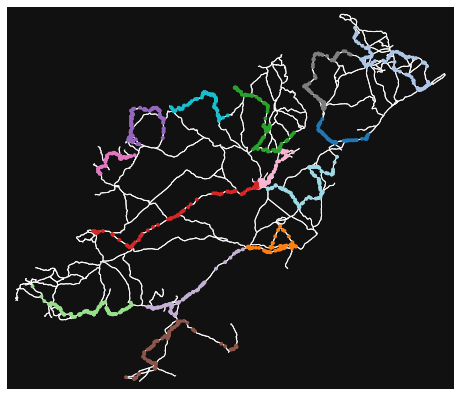

In [18]:
helper.plot_community_bus_routes(G_110cutoff)

Using the cutoff=110 simple paths as the community bus routes.

Now any nodes on these routes that are adjacent to edges
with no population (as assigned earlier) will be removed.
The remaining nodes will give the location of bus stops.

Find the maximum degree value for the graph's nodes. That is the most possible adjacent edges a node can have in this graph.
Then use this max. to keep only nodes with a weighted degree less than that.
This list of nodes will then be used to remove community_route flag from those nodes in the graph

In [19]:
degrees = dict(list(G_110cutoff.degree()))
max_degrees = max(degrees.values())
weighted_degrees = dict(list(G_110cutoff.degree(weight="weight")))

no_population_nodes = [k for k, v in weighted_degrees.items() if v <= max_degrees]

In [20]:
# Set community_route=False for all those nodes
for node in no_population_nodes:
    G_110cutoff.nodes[node]["community_route"] = False
community_route_nodes = [x for x,y in G_110cutoff.nodes(data=True) if y["community_route"]]
len(community_route_nodes)

673

Left with around half the original number of community route nodes.

Save and plot the final community routes

In [21]:
ox.save_graphml(G_110cutoff, filepath=f"{config.rp_graphml_path}/community_routes_cutoff110.graphml")


In [22]:
G_community_routes = ox.load_graphml(filepath=f"{config.rp_graphml_path}/community_routes_cutoff110.graphml")

nodes, edges = ox.graph_to_gdfs(G_community_routes)
# osmnx saved graph writes boolean values as strings so converting those
bool_replace = {"True": True, "False": False}
nodes["community_route"] = nodes["community_route"].map(bool_replace)
route_nodes = nodes[(nodes["community_route"])]

# get community route endpoints to add to plot
route_endpoint_nodes = nodes[(nodes["route_flag"] == "1") | (nodes["route_flag"] == "2")]
# map u and v to 1 and 2 route_flag values,
# to differentiate from community labels
flag_replace = {"1": "u", "2": "v"}
route_endpoint_nodes["route_flag"] = route_endpoint_nodes["route_flag"].map(flag_replace)
route_endpoint_nodes

/home/danny/College/donegal-bus-routes/venv1/lib/python3.8/site-packages/geopandas/geodataframe.py:831: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super(GeoDataFrame, self).__setitem__(key, value)


,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,highway
262459232,55.116530,-7.460112,262459232,0,0.0006952453004233725,POINT (-7.46011 55.11653),2,u,True,0,NaN
258601523,55.078196,-7.262014,258601523,0,0.0006139705257041413,POINT (-7.26201 55.07820),7,v,True,58,NaN
258453962,55.343979,-7.317372,258453962,1,0.0007478161903782531,POINT (-7.31737 55.34398),8,u,True,0,NaN
1574232524,55.258801,-7.147864,1574232524,1,0.0008153067340908409,POINT (-7.14786 55.25880),4,v,True,110,NaN
1898286788,55.034133,-7.587842,1898286788,10,0.0007360907343096448,POINT (-7.58784 55.03413),5,u,True,0,NaN
788873005,54.945378,-7.740528,788873005,10,0.0006238826825071857,POINT (-7.74053 54.94538),10,v,True,110,mini_roundabout
2113423914,55.145810,-7.450275,2113423914,11,0.0006140181838969793,POINT (-7.45028 55.14581),5,u,True,0,NaN
258438279,55.276962,-7.337777,258438279,11,0.0005849382994212507,POINT (-7.33778 55.27696),10,v,True,71,NaN
794807698,55.125735,-7.869462,794807698,14,0.0006771284060073162,POINT (-7.86946 55.12573),1,u,True,0,NaN
601118054,55.145993,-8.114570,601118054,14,0.0005048137865957919,POINT (-8.11457 55.14599),12,v,True,82,NaN


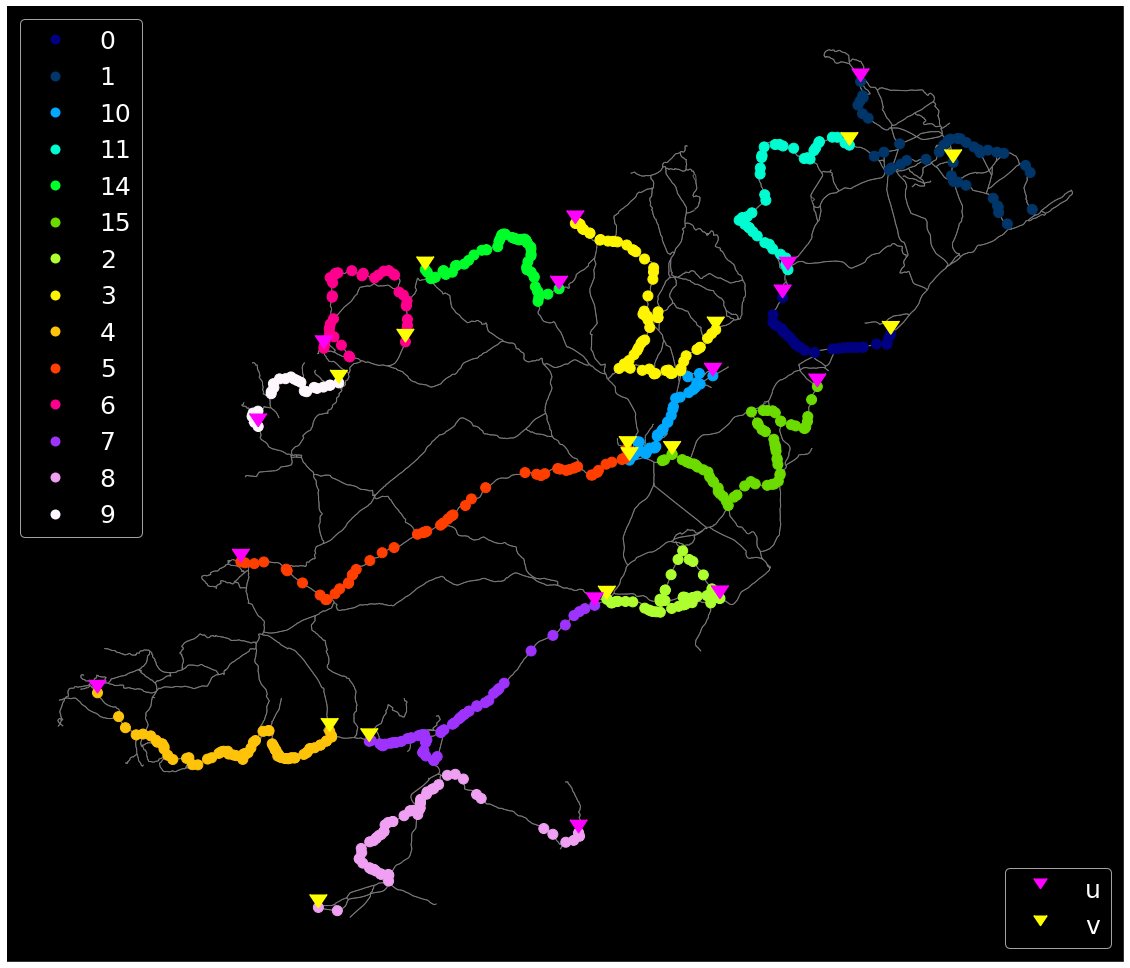

In [23]:

fig, ax = helper.plot_community_graph(route_nodes,
                                      edges,
                                      nodes_cmap="gist_ncar",
                                      legend=True)
legend1 = ax.get_legend()
route_endpoint_nodes.plot(
    ax=ax,
    marker=7,
    markersize=300,
    column="route_flag",
    cmap="spring",
    zorder=2,
    legend=False,
    categorical=True
)

p1, p2 = [child for child in ax.get_children()
          if isinstance(child, plt.collections.PathCollection)]

# get legend elements and update marker size
leg_elements = p2.legend_elements()
for x in leg_elements[0]:
    x.set_markersize(20)
# and update labels
leg_elements[1][0] = "u"
leg_elements[1][1] = "v"

l2 = ax.legend(*leg_elements,
               loc=4) # this removes original legend from the axes.
# add it back
ax.add_artist(legend1)
# update legend font colour
leg_colour = plt.pyplot.setp(ax.get_legend().get_texts(), color='w')

4 areas have been identified that would benefit from connecting routes:
Route A = C4(u) to C5(u)
Route B = C5(u) to C9(u)
Route C = C0(v) to C1(v)
Route D = C2(v) to C15(v)

Note: route_flag 1=u, 2=v

Add a connection flag and ordering to all nodes and Create sub-graphs for these regions
so that paths can be plotted.

In [24]:
nx.set_node_attributes(G_community_routes, None, "connection")
nx.set_node_attributes(G_community_routes, -1, "connection_order")

In [25]:
# Route A
nodes_a = []
for x, y in G_community_routes.nodes(data=True):
    if y["community"] == "4" or y["community"] == "5":
        nodes_a.append(x)
graph_a = G_community_routes.subgraph(nodes_a)

# Route B
nodes_b = []
for x, y in G_community_routes.nodes(data=True):
    if y["community"] == "5" or y["community"] == "9":
        nodes_b.append(x)
graph_b = G_community_routes.subgraph(nodes_b)

# Route C
nodes_c = []
for x, y in G_community_routes.nodes(data=True):
    if y["community"] == "0" or y["community"] == "1":
        nodes_c.append(x)
graph_c = G_community_routes.subgraph(nodes_c)

# Route D
nodes_d = []
for x, y in G_community_routes.nodes(data=True):
    if y["community"] == "2" or y["community"] == "15":
        nodes_d.append(x)
graph_d = G_community_routes.subgraph(nodes_d)

In [34]:
%%time
graph_a_nodes = ox.graph_to_gdfs(graph_a, edges=False)
a_start = list(graph_a_nodes[(graph_a_nodes["route_flag"] == "1") &
                     (graph_a_nodes["community"] == "4")]["osmid"])[0]
a_end = list(graph_a_nodes[(graph_a_nodes["route_flag"] == "1") &
                     (graph_a_nodes["community"] == "5")]["osmid"])[0]
path_a = helper.find_highest_weighted_simple_path(graph_a,
                                                  cutoff=110,
                                                  start_node=a_start,
                                                  end_node=a_end)
print(f"----------------\n"
      f"Connecting Route A:\n"
      f"path weight: {helper.path_weight(graph_a, path_a)} \n"
      f"path: {path_a}\n"
      f"----------------\n")

graph_b_nodes = ox.graph_to_gdfs(graph_b, edges=False)
b_start = list(graph_b_nodes[(graph_b_nodes["route_flag"] == "1") &
                     (graph_b_nodes["community"] == "5")]["osmid"])[0]
b_end = list(graph_b_nodes[(graph_b_nodes["route_flag"] == "1") &
                     (graph_b_nodes["community"] == "9")]["osmid"])[0]
path_b = helper.find_highest_weighted_simple_path(graph_b,
                                                  cutoff=110,
                                                  start_node=b_start,
                                                  end_node=b_end)
print(f"----------------\n"
      f"Connecting Route B:\n"
      f"path weight: {helper.path_weight(graph_b, path_b)} \n"
      f"path: {path_b}\n"
      f"----------------\n")

graph_c_nodes = ox.graph_to_gdfs(graph_c, edges=False)
c_start = list(graph_c_nodes[(graph_c_nodes["route_flag"] == "2") &
                     (graph_c_nodes["community"] == "0")]["osmid"])[0]
c_end = list(graph_c_nodes[(graph_c_nodes["route_flag"] == "2") &
                     (graph_c_nodes["community"] == "1")]["osmid"])[0]
path_c = helper.find_highest_weighted_simple_path(graph_c,
                                                  cutoff=110,
                                                  start_node=c_start,
                                                  end_node=c_end)
print(f"----------------\n"
      f"Connecting Route C:\n"
      f"path weight: {helper.path_weight(graph_c, path_c)} \n"
      f"path: {path_c}\n"
      f"----------------\n")

graph_d_nodes = ox.graph_to_gdfs(graph_d, edges=False)
d_start = list(graph_d_nodes[(graph_d_nodes["route_flag"] == "2") &
                     (graph_d_nodes["community"] == "2")]["osmid"])[0]
d_end = list(graph_d_nodes[(graph_d_nodes["route_flag"] == "2") &
                     (graph_d_nodes["community"] == "15")]["osmid"])[0]

path_d = helper.find_highest_weighted_simple_path(graph_d,
                                                  cutoff=110,
                                                  start_node=d_start,
                                                  end_node=d_end)
print(f"----------------\n"
      f"Connecting Route D:\n"
      f"path weight: {helper.path_weight(graph_d, path_d)} \n"
      f"path: {path_d}\n"
      f"----------------\n")

----------------
Connecting Route A:
path weight: 1928.0 
path: [2031126838, 507651123, 1279748374, 2031154660, 1994336918, 798623772, 798623783, 1799568408, 825408334, 3077575432, 3158695147, 3158695167, 3158695284, 1799609484, 1799609483, 798620217, 33246656, 3155541230, 1464931807, 3155543276, 825408316, 1990958883, 2812915169, 790572219, 458538348, 262491414, 1957193061, 262491412, 1957193278, 1956821706, 262491406, 1956822031, 790572056, 2186495333, 458538245, 458538240, 262491394, 1918855503, 1918855459, 1918855668, 2004182599, 262489090, 1918855456, 1919296787, 1435301486, 1900372484, 1900372442, 262489073, 1919296965, 1918823653, 1900372783, 1897106315, 1801652425, 1882111674, 262488762, 1877345156, 262488759, 981465551, 1877345159, 262488756, 262488755, 2173326568, 1801652344, 1897106073, 506379202, 1801638656, 1801652441, 1897106514, 1881142727, 6991136843, 506379180, 1923453236, 506379167, 1881571305, 6276206325, 6276206533, 1881154095, 911533198, 6991136877, 1881571642, 190

In [35]:
connecting_paths = [path_a, path_b, path_c, path_d]
labels = ["a", "b", "c", "d"]
i = 0
for path in connecting_paths:
    j = 0
    for node in path:
        G_community_routes.nodes[node]["connection"] = labels[i]
        G_community_routes.nodes[node]["connection_order"] = j
        j += 1
    i += 1
connection_route_nodes = [x for x,y in G_community_routes.nodes(data=True) if y["connection"]]
len(connection_route_nodes)

398

Again remove nodes from these routes that have no adjacent "populated" edges

In [36]:
helper.convert_edge_weights_to_floats(G_community_routes)
degrees = dict(list(G_community_routes.degree()))
max_degrees = max(degrees.values())
weighted_degrees = dict(list(G_community_routes.degree(weight="weight")))

no_population_nodes = [k for k, v in weighted_degrees.items() if v <= max_degrees]

# Set connection=None for all those nodes
for node in no_population_nodes:
    G_community_routes.nodes[node]["connection"] = None
connection_route_nodes = [x for x,y in G_community_routes.nodes(data=True) if y["connection"]]
len(connection_route_nodes)

202

In [37]:
ox.save_graphml(G_community_routes, filepath=f"{config.rp_graphml_path}/all_routes.graphml")



In [38]:
G_all_routes = ox.load_graphml(filepath=f"{config.rp_graphml_path}/all_routes.graphml")

nodes, edges = ox.graph_to_gdfs(G_all_routes)
# osmnx saved graph writes boolean values as strings so converting those
bool_replace = {"True": True, "False": False}
nodes["community_route"] = nodes["community_route"].map(bool_replace)
route_nodes = nodes[(nodes["community_route"])]

# get community route endpoints to add to plot
connecting_labels = ["a", "b", "c", "d"]
connecting_routes = nodes[nodes["connection"].isin(connecting_labels)]
connecting_routes

,y,x,osmid,community,rank,geometry,top_n,route_flag,community_route,community_route_order,connection,connection_order,highway
1315472999,55.092073,-7.236511,1315472999,0,0.00021349047169070978,POINT (-7.23651 55.09207),0,0,False,-1,c,3,NaN
1411715929,55.098324,-7.227837,1411715929,0,0.0003273074494427055,POINT (-7.22784 55.09832),0,0,False,-1,c,4,NaN
258601523,55.078196,-7.262014,258601523,0,0.0006139705257041413,POINT (-7.26201 55.07820),7,2,True,58,c,0,NaN
258601531,55.083195,-7.251692,258601531,0,0.00018417402425828833,POINT (-7.25169 55.08319),0,0,False,-1,c,2,NaN
1417675407,55.262106,-7.197462,1417675407,1,0.0005408273474972668,POINT (-7.19746 55.26211),0,0,True,45,c,51,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877528011,54.955285,-8.379846,1877528011,9,0.00027815270487378173,POINT (-8.37985 54.95529),0,0,False,-1,b,98,NaN
1880150083,54.975291,-8.416811,1880150083,9,0.00012849122083648156,POINT (-8.41681 54.97529),0,0,False,-1,b,106,NaN
1880486988,54.965832,-8.411555,1880486988,9,0.00023305863961389233,POINT (-8.41155 54.96583),0,0,False,-1,b,104,NaN
1877572732,54.948157,-8.357480,1877572732,9,0.000614976852934095,POINT (-8.35748 54.94816),5,0,False,-1,b,86,NaN


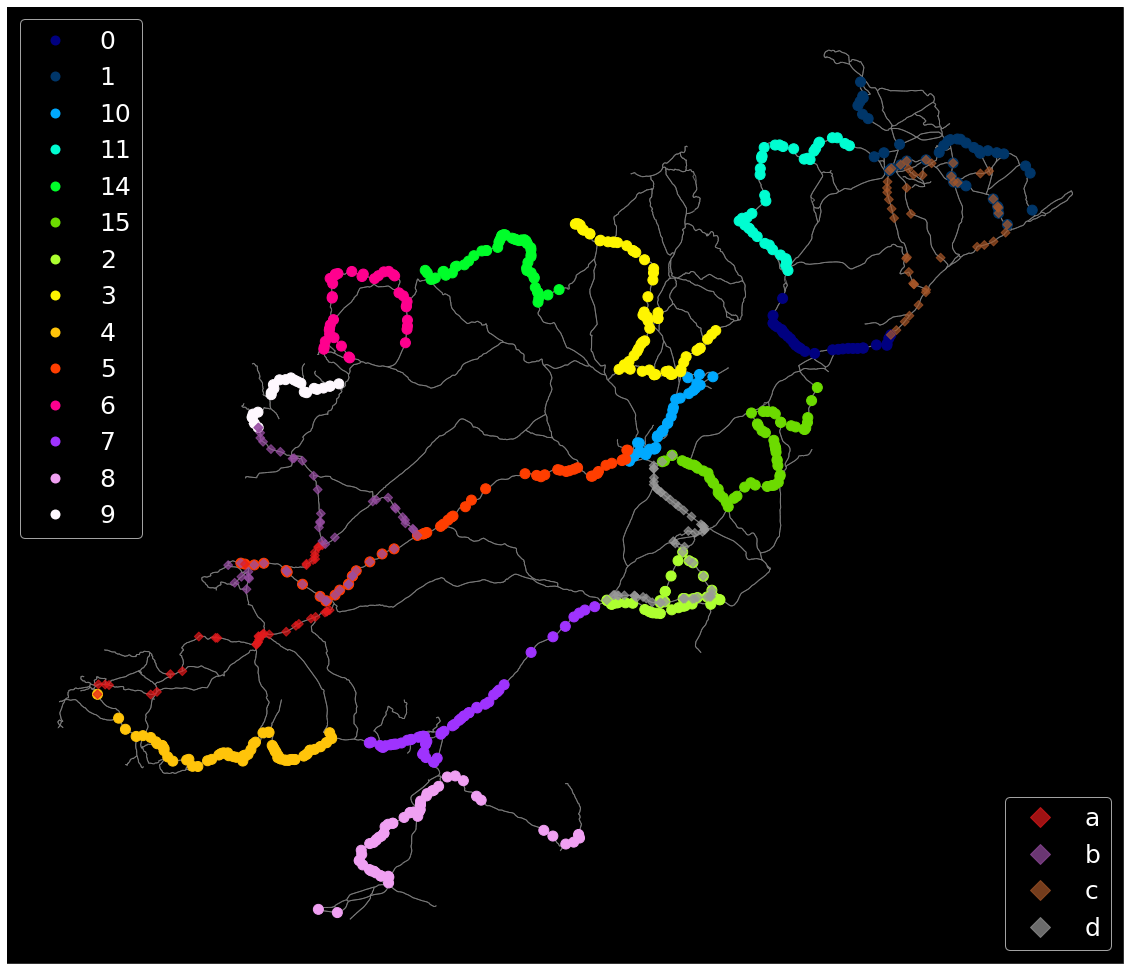

In [39]:

fig, ax = helper.plot_community_graph(route_nodes,
                                      edges,
                                      nodes_cmap="gist_ncar",
                                      legend=True)
legend1 = ax.get_legend()
connecting_routes.plot(
    ax=ax,
    marker="D",
    markersize=40,
    column="connection",
    cmap="Set1",
    zorder=2,
    alpha=0.7,
    legend=False,
    categorical=True
)

p1, p2 = [child for child in ax.get_children()
          if isinstance(child, plt.collections.PathCollection)]

# get legend elements and update marker size
leg_elements = p2.legend_elements()
for x in leg_elements[0]:
    x.set_markersize(20)
# and update labels
leg_elements[1][0] = "a"
leg_elements[1][1] = "b"
leg_elements[1][2] = "c"
leg_elements[1][3] = "d"

l2 = ax.legend(*leg_elements,
               loc=4) # this removes original legend from the axes.
# add it back
ax.add_artist(legend1)
# update legend font colour
leg_colour = plt.pyplot.setp(ax.get_legend().get_texts(), color='w')